<a href="https://colab.research.google.com/github/clacri/iucr2020_compschool/blob/main/randy_covariance/CovarianceMatrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding and manipulating covariance matrices

Randy J Read, Cambridge Institute for Medical Research, University of Cambridge, rjr27@cam.ac.uk

## Preamble

The following background is assumed: an understanding of how to multiply matrices and vectors, the concept of an inverse matrix, familiarity with the ideas of eigenvalues and eigenvectors. Some basic knowledge of Python will help.

The following mathematical notation is used: italic lower case for variables representing real numbers (*e.g.* $x$), bold lower case for both complex numbers ($\mathbf{z}$) and vectors ($\mathbf{v}$) and bold upper case for matrices ($\mathbf{A}$). A vector should be understood to be a column vector by default (*e.g.* $\mathbf{x} = \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix}$)

In [1]:
# Set up, including importing the libraries we will need
%matplotlib inline
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import scipy
from scipy import stats

Before we start looking at various flavours of normal distributions (which are described by variances or, more generally, covariance matrices), let's review the Central Limit Theorem, which underpins the importance of normal distributions.

## The Central Limit Theorem and normal distributions

Normal distributions appear everywhere in experimental science. This is because most of the things we observe result from adding up a variety of sources of variation: different contributions to the signal and to the error in the signal. We can think of the observation as a sum of random variables describing these different contributions to signal and error. The Central Limit Theorem tells us that, as the number of random variables contributing to a sum increases, the probability distribution of the sum approaches ever closer to a normal distribution.

A normal distribution for a single variable (often called a Gaussian or referred to as the bell-shaped curve) is described by two parameters: the mean (expected value, *i.e.* probability-weighted average over all possible values) and the variance (or its square root, the standard deviation). According to the Central Limit Theorem, if the random variables are independent of one another (uncorrelated), the expected value of the distribution of their sum is the sum of the expected values of the individual random variables, and the variance of the distribution of the sum is the sum of the individual variances:

$s = \sum_j x_j$, where the individual $x_j$ are different random variables in the sum

$\mu = \left<s\right> = \sum_j \left<x_j\right>$, where $\left<s\right>$ indicates the probability-weighted average, i.e. $\left<s\right> = \int_s p(s)\,s\,ds$

$\sigma^2 = \sigma^2_s = \sum_j \sigma^2_{x_j}$, where $\sigma^2_{x_j} = \left<(x_j - \left<x_j\right>)^2\right>$ or the mean-square deviation from the mean.

The expected value and variance define the normal distribution:

$p(s) = \frac{1}{\sqrt{2 \pi \sigma^2}}\exp(-\frac{(s - \mu)^2}{2 \sigma^2})$

There are a few conditions to this. First, there must be a sufficient number of random variables in the sum, though as we will see even as few as 5 or 10 can result in something reasonably close to a normal distribution. Second, none of the variables can dominate the distribution. Of course, the means and variances of the individual random variables have to be defined and finite.

It's easy to demonstrate the Central Limit Theorem and its limitations with some simple numerical experiments. For instance, a top-hat function (a flat function that is only non-zero between two defined values) doesn't look anything like a normal distribution. We can use a top-hat function to represent the probability distribution of numbers drawn randomly from the range $0 \leq x < 1$.

<function matplotlib.pyplot.show>

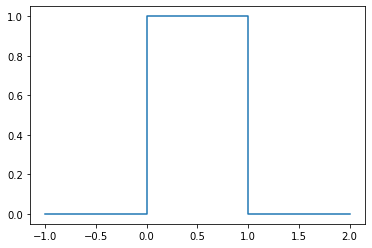

In [2]:
plt.step([-1,0,1,2],[0,0,1,0])
plt.show

Note that the area under the top-hat function is one: in a distribution that covers the probability of all possible outcomes, the total probability has to add up to one, because something has to happen!

We can generate a set of numbers from that distribution and look at the histogram of their values to make sure they're being generated correctly.

<function matplotlib.pyplot.show>

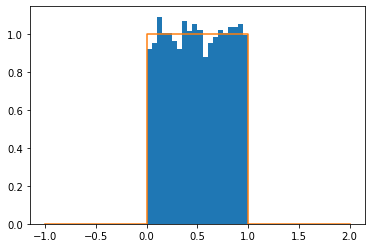

In [3]:
nx = 5000
x = np.random.random_sample(nx)
plt.hist(x,bins=20,density=True)
plt.step([-1,0,1,2],[0,0,1,0])
plt.show

Let's compare the distribution of sums of random numbers in the range 0 to 1 with the normal distribution. The expected value for each random number is $\frac{1}{2}$, so the sum of the expected values is the number of samples divided by 2. The variance of the distribution for each random number is given by

$\sigma^2 = \int_0^1\,(x-\frac{1}{2})^2\,dx = \frac{1}{12}$ 

so the variance of the sum is obtained by dividing the number of samples by 12.

Even a sample of 10 numbers drawn from the same top-hat distribution is enough for the normal distribution to be a good approximation for their sum.

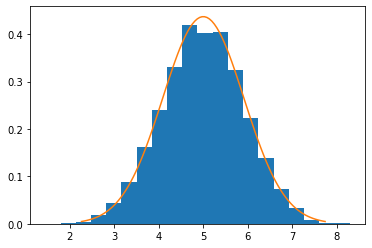

In [4]:
nsamp = 10
mu = nsamp / 2.
variance = nsamp / 12. 
sigma = np.sqrt(variance)
ndata = 5000
data = []
for i in range(ndata):
    data.append(np.sum(np.random.random_sample(nsamp)))
plt.hist(data,bins=20,density=True)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

### Exercise on effect of sample size on the Central Limit Theorem

Look at the effect of changing the number of samples in the distribution above by changing *nsamp*. Include 1 and 2 in the values you try!

## Breaking the assumptions of the Central Limit Theorem

However, if we replace even 1 of those 10 random numbers with a random number drawn from a wider range (and adjust the mean and variance appropriately), the distribution is no longer normal. What we get is a compromise between the flat distribution for a single number drawn from the broader distribution (shown as a top-hat function shifted by the mean contribution from the smaller variables) and the normal distribution from the rest of the smaller terms. We would have to add many samples from the narrower distribution to make the normal distribution a good approximation again. (You can play with this by changing *nsmall*. Try changing the breadth of the "big" distribution too!)

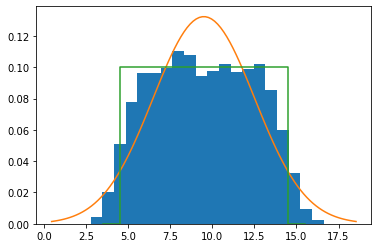

In [5]:
nsmall = 9
small = 1
nbig = 1
big = 10
mu = (nbig*big + nsmall*small) / 2.
variance = (nbig*big**2 + nsmall*small**2) / 12.
sigma = np.sqrt(variance)
ndata = 5000
data = []
for i in range(ndata):
    data.append(np.sum(big  *np.random.random_sample(nbig))
              + np.sum(small*np.random.random_sample(nsmall)))
plt.hist(data,bins=20,density=True)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
if (nbig == 1): # Only plot top-hat for case of 1 sample from the broad distribution
    plt.step([mu-big/2-1, mu-big/2, mu+big/2, mu+big/2+1],
             [0, 0, 1/big, 0])
plt.show()

What is going on here is that every time we add a new random variable, the distribution so far is broadened by a convolution with the distribution of the new variable. Hopefully you've encountered convolutions before, but if not you can think of a convolution as smearing one function out by the shape of the other function. In the limit (with variables that have similar variances), this tends to a normal distribution regardless of the shapes of the individual distributions. Here, the top-hat distribution for the big variable is smeared out by the much smaller variation from the approximate normal distribution of the sum of the remaining terms, and that's not enough to lose its flat top. Nonetheless, if you add enough of the smaller contributions (say, 100 of them in this case), you will get something close to a normal distribution again.

Note that the Central Limit Theorem can be generalised to higher dimensions (the multivariate normal distribution relating collections of real numbers), complex numbers (the complex normal distribution) or both (the multivariate complex normal distribution). We'll be looking at these, particularly the multivariate versions that require a covariance matrix to describe them.

### Exercise on effect of a dominant variable in the Central Limit Theorem


See what happens as you increase *nbig* in the simulation above to larger numbers, or if you reduce *nsmall*.

## The multivariate normal distribution

An alternative way of expressing the normal distribution makes the generalisation to the multivariate case easier to follow:

$p(x) = (2 \pi \Sigma)^{-1/2} \exp(-\frac{1}{2}(x - \mu) \Sigma^{-1} (x - \mu))$, where $\Sigma = \sigma^2 = \left<(x-\mu)(x-\mu)\right>$

Turning this into an expression for the multivariate normal distribution simply involves replacing the variables $x$ and $\mu$ by vectors and replacing the scalar $\Sigma$ by a covariance matrix.

$p(\mathbf{x}) = (|2 \pi\boldsymbol{\Sigma}|^{-1/2} \exp(-\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}))$

where $|2 \pi\mathbf\Sigma|$ indicates the determinant of $2 \pi$ times the covariance matrix (which is a nice shorthand that is equal to the product of the determinant of the matrix and $2 \pi$ raised to the order of the matrix) and a superscript $T$ indicates the transpose of the vector. In this equation, $\mathbf{x}$ and $\boldsymbol{\mu}$ are column vectors: the product $\boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})$ is therefore also a column vector so that when it is premultiplied by the row vector $(\mathbf{x} - \boldsymbol{\mu})^T$, giving the inner or dot product of the vectors, the result is a real number.

Note that we can also generalise the expression for the covariance matrix from the expression for the 1D variance of the normal distribution. Reversing the row and column vectors gives us the outer product, *i.e.* a matrix. This way of expressing the covariance matrix will turn out to be very useful later!

$\boldsymbol{\Sigma} = \left<(\mathbf{x} - \boldsymbol{\mu})(\mathbf{x} - \boldsymbol{\mu})^T\right>$ = 
$\begin{bmatrix} 
\left<(x_1 - \mu_1)(x_1 - \mu_1)\right> & \cdots & \left<(x_1 - \mu_1)(x_n - \mu_n)\right> \\
\vdots & \ddots & \vdots \\
\left<(x_n - \mu_n)(x_1 - \mu_1)\right> & \cdots & \left<(x_n - \mu_n)(x_n - \mu_n)\right> 
\end{bmatrix}$

The diagonal elements of this matrix are the variances of the individual variables, and the off-diagonal elements are the covariances, which are related to correlations. It's important to note that the covariances are calculated without assuming values for any other variables to which they might both be correlated. In some circumstances, you might have to integrate over all possible values of such *nuisance* variables.

We can get an intuitive idea of how this works by looking at a bivariate (two-dimensional) distribution, replacing the vector $\mathbf{x}$ with the vector $\begin{bmatrix}x\\y\end{bmatrix}$. The triple product inside the exponential (sometimes called the quadratic form) can be expanded out into a relatively simple form:

$(\mathbf{x} - \boldsymbol{\mu})^T\,\boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) = 
\begin{bmatrix} (x - \mu_x) & (y - \mu_y) \end{bmatrix}
\begin{bmatrix} \sigma^2_x & \sigma_{xy} \\ \sigma_{xy} & \sigma^2_y \end{bmatrix}^{-1}
\begin{bmatrix} (x - \mu_x) \\ (y - \mu_y) \end{bmatrix}$, 

where $\sigma_{xy} = \left<(x - \mu_x)(y - \mu_y)\right>$

To see the relationship between  covariance and  correlation, note that the definition of the correlation between $x$ and $y$ is $\rho_{xy} = \frac{\sigma_{xy}}{\sigma_x \sigma_y}$. If we normalised $x$ and $y$ (and their expected values) by dividing by their standard deviations, the covariance matrix relating them would turn into a correlation matrix: $\begin{bmatrix} 1 & \rho_{xy} \\ \rho_{xy} & 1 \end{bmatrix}$.

How the probability distribution depends on the standard deviations and the correlation coefficient can be explored by viewing it in a contour plot below.

In [6]:
# Start by defining functions to return a 2D grid for the contour plot and to 
# annotate with arrows.

def make_grid(center, sigmas, ndat=60):
    x = np.linspace(center[0]-3*sigmas[0], center[0]+3*sigmas[0], ndat)
    y = np.linspace(center[1]-3*sigmas[1], center[1]+3*sigmas[1], ndat)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))
    return x, y, pos

def annotate_arrow(ax, start, end):
    ax.annotate("",
            xy = end, # Square root to show standard deviation
            xycoords='data',
            xytext=start, 
            textcoords='data',
            arrowprops=dict(arrowstyle="->",shrinkA=0,shrinkB=0))

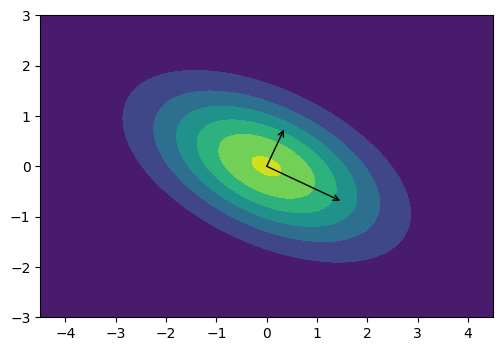

In [7]:
sigmax = 1.5
varx = sigmax**2
sigmay = 1
vary = sigmay**2
corrxy = -0.5
covarxy = sigmax * sigmay * corrxy
Sigma = np.array([[varx, covarxy],[covarxy, vary]])
mu = np.array([0,0])

# Now do a contour plot of the distribution
fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_dpi(100)
# Add the eigenvectors showing the principal axes
# Note that eigenvectors are in the columns, and the eigenvalues are the 
# variances of those components
w,v = linalg.eig(Sigma)
end = mu + np.sqrt(w[0])*v[:,0] # Square root to show standard deviation
annotate_arrow(ax, mu, end)
end = mu + np.sqrt(w[1])*v[:,1]
annotate_arrow(ax, mu, end)
x, y, pos = make_grid(np.array((0,0)),np.array((sigmax,sigmay))) # 2D grid for plotting
bivardist = stats.multivariate_normal(mu,Sigma) # Define the distribution
plt.contourf(x,y,bivardist.pdf(pos)) # Plot over grid
plt.show()

The two arrows on the contour plot are the eigenvectors of the covariance matrix, scaled by the square root of the corresponding eigenvalue to show a one-standard-deviation shift.

When we go to higher dimensions than two, it may seem surprising that all we need is pairwise cross-terms, because there is higher-order behaviour in the joint distribution: the probability of values taken by two of the variables will depend on the values of other variables to which both are correlated. However, this higher-order information emerges from the step where the covariance matrix is inverted.

### Exercise on varying correlation and standard deviations

Make a copy of the cell above (because you'll want to refer to the original contour plot later). Try changing the parameters in your copy, *i.e.* the two standard deviations and the correlation coefficient, to see how these affect the distribution.

## Deriving distributions of subsets of variables in a multivariate normal distribution

Apart from being very common, multivariate normal distributions have many useful properties that allow us to perform easy manipulations. For instance, we frequently know the joint distribution of a number of variables (expressed as a multivariate normal distribution) but what we really need is the joint distribution of a smaller number of them. This comes in two flavours: either we don't know or care about the values of the subset of variables we want to leave out, or we do know them and we want to know the effect of fixing the ones we know on the rest of the variables. The first flavour corresponds to a marginal probability distribution and the second to a conditional probability distribution. In both cases, the new distribution is also a normal distribution, but one with reduced dimensions.

### Marginal probability distributions

To obtain a probability distribution that doesn't depend on the values of any variables left out, in principle we have to integrate over all possible values of the variables we're leaving out, weighting the integral by the probabilities of those values. (This is called a marginal probability distribution, because you can think of the integration over one or more variables as projecting the higher-dimensional distribution onto the corresponding margin of the sample space.) However, remember that we constructed the covariance matrix by looking only at pairs of variables, and each covariance element was derived assuming that we didn't know the values of nuisance variables to which both might be correlated. We could, in fact, have used the same results to build the covariance matrix of the smaller subset of variables. This means that we can derive the marginal probability distribution simply by discarding the variables we don't want, including the corresponding rows and columns of the covariance matrix and the elements of the expected value vector.

Here's a simple example where we derive a univariate normal distribution from the bivariate distribution illustrated above. In the contour plot above, the probabilities of different values of $x$ depend on the value of $y$, with negative values of $y$ leading to more positive values of $x$ and *vice versa*. However, if we imagine projecting the distribution down the $y$ axis, we can see that the overall average value of $x$ is zero. The following shows how we can get this result simply by discarding the terms relating to the $y$ variable from above.

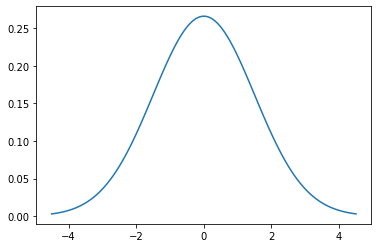

In [8]:
mux = 0
sigmax = 1.5
x = np.linspace(mux - 3*sigmax, mux + 3*sigmax, 100)
plt.plot(x, stats.norm.pdf(x, mux, sigmax))
plt.show()

### Conditional probability distributions

Manipulating the higher-order covariance matrix to obtain the covariance matrix for a lower-order conditional probability distribution is a bit more complicated, but still relatively simple.

Let's take the bivariate probability distribution as an example. Imagine that we know the value of $y$ and would like to know the probability distribution for $x$ once $y$ is fixed. One way to do this is to fix the value of $y$ in the equation for the bivariate distribution (equivalent to taking a horizontal slice of the bivariate distribution), then work out the normalisation factor that is required to make the integral of the probability distribution for $x$ equal to one, as it should be for a proper probability distribution. Looking at the contour plot above, we can see, for instance, that if the value of $y$ was fixed to 1, the expected value of $x$ would be closer to -1 than to 0.

Those manipulations can be shortcut by the following procedure. To obtain the variance of $x$ conditional on a particular value of $y$, we take its original variance, $\sigma_x^2$, and subtract the variance accounted for by fixing $y$, which turns out to be $\sigma_{xy}\frac{1}{\sigma_y^2} \sigma_{xy}$ (written that way for a reason that will become clearer in a moment). Perhaps surprisingly, and helpfully, the conditional variance doesn't depend on the value to which $y$ is fixed.

$\sigma_{x|y}^2 = \sigma_x^2 - \sigma_{xy} \frac{1}{\sigma_y^2} \sigma_{xy}$

You can see that, the higher the correlation between the fixed variable and the remaining variable, the more the variance in the remaining random variable is reduced by knowing the fixed variable. This is true, as well, of higher-order probabilities with multiple fixed and remaining random variables.

The new expected value for $x$ is given by a related expression: 

$\mu_{x|y} = \mu_x + \sigma_{xy} \frac{1}{\sigma_y^2} (y - \mu_y)$

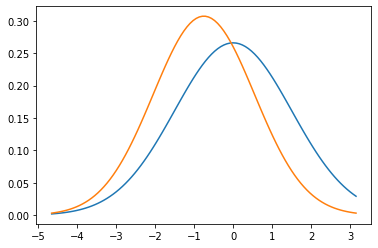

In [9]:
# Define parameters for original bivariate distribution in contour plot above
mux = muy = 0
sigmax = 1.5
varx = sigmax**2
sigmay = 1
vary = sigmay**2
corrxy = -0.5
covarxy = sigmax * sigmay * corrxy

# Fix value of y, and define variance and expected value for x conditional on y
y = 1
varx_new = varx - (covarxy/sigmay)**2
sigmax_new = np.sqrt(varx_new)
mux_new = mux + (covarxy/sigmay)*(y - muy)
x = np.linspace(mux_new - 3*sigmax_new, mux_new + 3*sigmax_new, 100)
# Plot marginal distribution and conditional distribution
plt.plot(x, stats.norm.pdf(x, mux, sigmax))
plt.plot(x, stats.norm.pdf(x, mux_new, sigmax_new))

You can see in this plot that, as expected, the conditional distribution (orange) is slightly sharper than the marginal distribution (blue; the range of $x$ values is narrower and the peak is higher), because knowing the value of $y$ has reduced the variance in $x$.

This is even more useful when it is generalised to higher order multivariate distributions, where several variables are fixed at once and the remaining variables obey a multivariate normal distribution. It's easiest first to reorder the variables so that the fixed variables are at the end of the list and the remaining variables at the front. Once that is done, the covariance matrix can be partitioned into four blocks: smaller covariance matrices for the still-unknown variables (top left) and the known variables (bottom right), and two diagonal blocks with the covariances between the unknown and known variables.

$\boldsymbol{\Sigma} = 
\begin{bmatrix} \boldsymbol{\Sigma}_{11} & | & \boldsymbol{\Sigma}_{12} \\
\text{---} & | & \text{---} \\
\boldsymbol{\Sigma}_{21} & | & \boldsymbol{\Sigma}_{22} \end{bmatrix}$

The process used to derive the conditional probability distribution is a generalisation of the procedure above for turning a bivariate distribution into a conditional univariate distribution. The new covariance matrix for the remaining unknown variables is given by the following:

$\boldsymbol{\Sigma}_{1|2} = \boldsymbol{\Sigma}_{11} - \boldsymbol{\Sigma}_{12}\,\boldsymbol{\Sigma}_{22}^{-1}\,\boldsymbol{\Sigma}_{21}$,
where (because covariance matrices are symmetric) $\boldsymbol{\Sigma}_{21} = \boldsymbol{\Sigma}_{12}^T$.

The new vector of expected values for the remaining variables is given by the following:

$\boldsymbol{\mu}_{1|2} = \boldsymbol{\mu}_1 + \boldsymbol{\Sigma}_{12}\,\boldsymbol{\Sigma}_{22}^{-1}\,(\mathbf{x}_2-\boldsymbol{\mu}_2)$,
where $\boldsymbol{\mu}_1$ and $\boldsymbol{\mu}_2$ are the expected values of the remaining and fixed variables from the original distribution, and $\mathbf{x}_2$ is the vector of fixed values. The updated covariance matrix and expected value vector can now be used in the multivariate normal distribution to give us the conditional probability of the $\mathbf{x}_1$ subset of the variables given known values for the $\mathbf{x}_2$ subset. This conditional probability is typically denoted as $p(\mathbf{x}_1;\mathbf{x}_2)$ or $p(\mathbf{x}_1|\mathbf{x}_2)$.

The concepts we've been looking at are illustrated below by transforming a 4-dimensional multivariate normal distribution into 2-dimensional marginal distributions as well as a number of 2-dimensional conditional distributions corresponding to different values for the fixed variables. 

You could try playing with the starting parameters, but you have to make sure that the starting covariance matrix corresponds to a physically sensible probability distribution. The eigenvalues of the covariance matrix are the variances in the directions of the eigenvectors and they all have to be positive to be physically sensible. That means that the determinant of the matrix (which is the product of the eigenvalues) has to be positive.

Changed parameters for marginal probability of x1 and x2:
  sigma1 has changed from  1.5  to  1.0473180032826708
  sigma2 has changed from  0.8  to  0.6387487769068526
  rho12 has changed from  0.5  to  0.1569569852658064


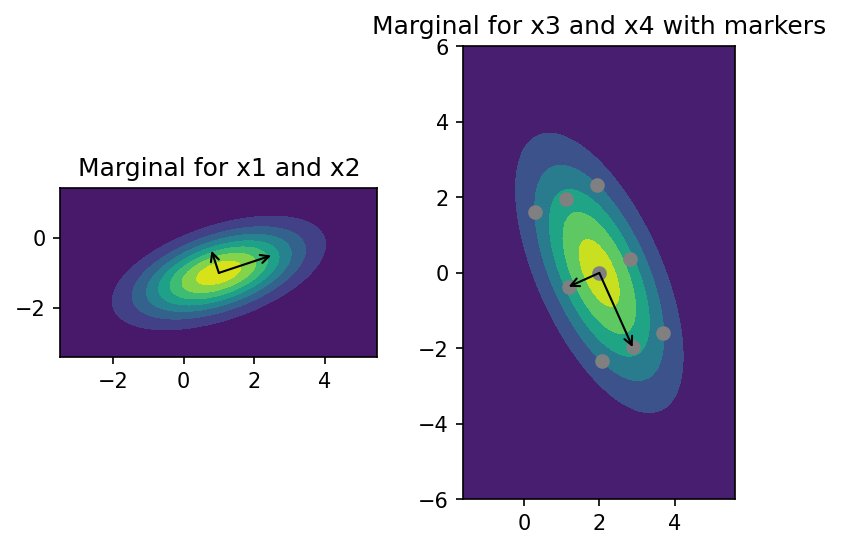

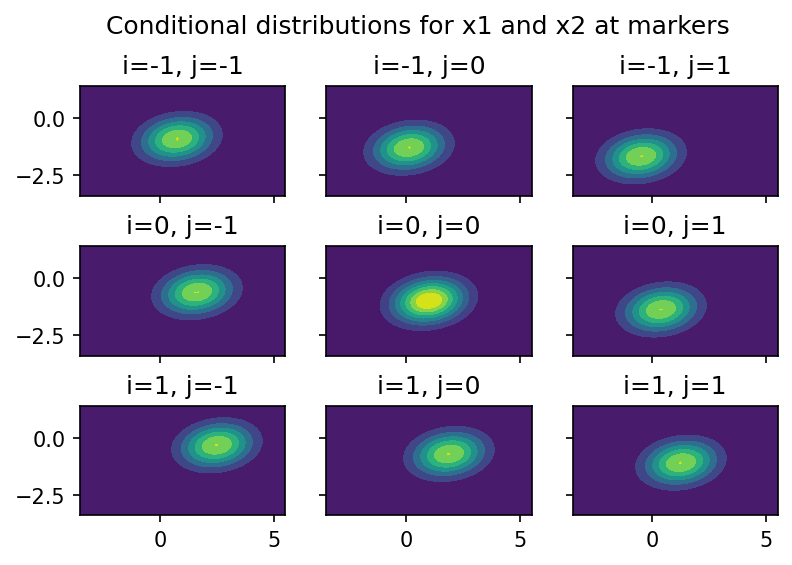

In [10]:
# Define 4x4 covariance matrix in terms of standard deviations (sigma) of 
# individual variables and their correlations (rho). Some choices of the 
# correlation parameters are not allowed because they will not lead to a 
# self-consistent covariance matrix. One obvious example of inconsistency is if 
# x1 and x2 are both highly positively correlated to x3, but the correlation 
# between x1 and x2 is highly negative; this can be detected by the determinant
# of the covariance matrix being negative. We will also avoid complications of 
# perfectly correlated variables (or linear combinations of variables), which
# lead to a determinant of zero.
sigma1 = 1.5
sigma2 = 0.8
sigma3 = 1.2
sigma4 = 2.
var1 = sigma1**2
var2 = sigma2**2
var3 = sigma3**2
var4 = sigma4**2
# Correlations have to be in the range -1 to 1, not including the endpoints
rho12 = 0.5
rho13 = -0.7
rho14 = 0.3
rho23 = -0.6
rho24 = 0.4
rho34 = -0.6
# Covariances defined in terms of correlation between two variables and their
# standard deviations
covar12 = rho12 * sigma1 * sigma2
covar13 = rho13 * sigma1 * sigma3
covar14 = rho14 * sigma1 * sigma4
covar23 = rho23 * sigma2 * sigma3
covar24 = rho24 * sigma2 * sigma4
covar34 = rho34 * sigma3 * sigma4

# For convenience, define expected values in terms of 2 arrays of length 2
mu1 = np.array([1.,-1.])
mu2 = np.array([2.,0.])
#
Sigma = np.array([[   var1, covar12, covar13, covar14],
                  [covar12,    var2, covar23, covar24],
                  [covar13, covar23,    var3, covar34],
                  [covar14, covar24, covar34,    var4]])
mu = np.concatenate((mu1,mu2))

# Check covariance matrix for consistency before proceeding
det = linalg.det(Sigma)
if (det > 0):
    # Start by plotting marginal joint distributions of x1/x2 and x3/x4
    fig1, ax1 = plt.subplots(1,2)
    fig1.set_dpi(150)
    
    # x1/x2 marginal joint distribution
    ax1[0].set_aspect("equal")
    ax1[0].set_title("Marginal for x1 and x2")
    # Make a 2-dimensional grid over variables x and y
    x1, y1, pos1 = make_grid(mu1,np.array((sigma1,sigma2)))
    Sigma11 = Sigma[0:2,0:2]
    # Add the eigenvectors showing the principal axes
    # Note that eigenvectors are in the columns, and the eigenvalues are the variances of those components
    w,v = linalg.eig(Sigma11)
    end1 = mu1 + np.sqrt(w[0])*v[:,0] # Square root to show standard deviation
    annotate_arrow(ax1[0], mu1, end1)
    end2 = mu1 + np.sqrt(w[1])*v[:,1] # Square root to show standard deviation
    annotate_arrow(ax1[0], mu1, end2)
    bivardist = stats.multivariate_normal(mu1,Sigma11)
    ax1[0].contourf(x1, y1, bivardist.pdf(pos1))
    
    # x3/x4 marginal joint distribution, with grid of fixed points used below for conditional probabilities
    ax1[1].set_aspect("equal")
    ax1[1].set_title("Marginal for x3 and x4 with markers")
    x2m, y2m, pos2m = make_grid(mu2,np.array((sigma3,sigma4)))
    Sigma22 = Sigma[2:4,2:4]
    w,v = linalg.eig(Sigma22)
    eigvec1_scaled = np.sqrt(w[0])*v[:,0]
    eigvec2_scaled = np.sqrt(w[1])*v[:,1]
    count = -1
    xsample = np.zeros(9)
    ysample = np.zeros(9)
    for i in range(-1,2):
        for j in range(-1,2):
            count += 1
            this_vec = mu2 + (i*eigvec1_scaled + j*eigvec2_scaled)
            xsample[count] = this_vec[0]
            ysample[count] = this_vec[1]
    end1 = mu2 + np.sqrt(w[0])*v[:,0] # Square root to show standard deviation
    annotate_arrow(ax1[1], mu2, end1)
    end2 = mu2 + np.sqrt(w[1])*v[:,1] # Square root to show standard deviation
    annotate_arrow(ax1[1], mu2, end2)
    bivardist = stats.multivariate_normal(mu2,Sigma22)
    ax1[1].contourf(x2m, y2m, bivardist.pdf(pos2m))
    ax1[1].scatter(xsample,ysample,color="grey")
    
    # Prepare for conditional probability of x1/x2 given x3/x4
    Sigma12 = Sigma[0:2,2:4]
    Sigma21 = Sigma12.transpose()
    Sigma22_inv = linalg.inv(Sigma22)
    Sigma11_new = Sigma11 - Sigma12.dot(Sigma22_inv).dot(Sigma21)
    sigma1_new = np.sqrt(Sigma11_new[0,0])
    sigma2_new = np.sqrt(Sigma11_new[1,1])
    rho12_new = Sigma11_new[0,1]/(sigma1_new*sigma2_new)
    print("Changed parameters for marginal probability of x1 and x2:")
    print("  sigma1 has changed from ",sigma1," to ",sigma1_new)
    print("  sigma2 has changed from ",sigma2," to ",sigma2_new)
    print("  rho12 has changed from ",rho12, " to ",rho12_new)
    fig2, ax2 = plt.subplots(3,3,sharex=True,sharey=True)
    fig2.set_dpi(150)
    fig2.suptitle("Conditional distributions for x1 and x2 at markers")
    regression_matrix = Sigma12.dot(Sigma22_inv)
    count = -1
    for i in range(-1,2):
        for j in range(-1,2):
            ind1 = i + 1
            ind2 = j + 1
            count += 1
            xy = np.array([xsample[count],ysample[count]])
            prod = regression_matrix.dot(xy)
            mu1_new = mu1 + Sigma12.dot(Sigma22_inv).dot(xy - mu2)

            # x1/x2 conditional joint distributions
            ax2[ind1,ind2].set_aspect("equal")
            ax2[ind1,ind2].set_title("i=" + str(i) + ", j=" + str(j))
            bivardist = stats.multivariate_normal(mu1_new,Sigma11_new)
            ax2[ind1,ind2].contourf(x1, y1, bivardist.pdf(pos1)) # Use grid from marginal probability
    
    plt.show()
else:
    print("Covariance matrix is non-positive definite with det = ",det)

Remember, we saw earlier that a conditional probability can be obtained by fixing the values of some variables (to make a slice of the higher dimensional probability) and then re-normalising so that the integral over all possible values is one. So the shape of the 2D conditional probability distributions above is the same as the shape of 2D slices in a 4D space (much harder to visualise!), just differing in the normalisation scale factor.

## Optional extra: the multiplication law of probabilities and Bayes' theorem

As a short digression, we can demonstrate a very important feature of joint probability distributions with conditional and marginal probability distributions like the ones we derived above. This applies to any conditional and marginal probabilities, not just multivariate normal distributions.

Consider the joint distribution of $x$ and $y$ shown above. We saw how we can transform it into either a marginal probability or a conditional probability. For the marginal probability, we could have integrated over all values of $x$ instead of $y$ to get the marginal probability distribution for $y$. Going back to the conditional probability of $x$ given $y$, we can think of that as being a renormalised line sliced from the joint distribution along a particular value of $y$. To renormalise it, we integrate along that line, then divide the values by that integral so that a new integral will come to one (as required for a sensible probability distribution that covers all possible outcomes). Notice that the integral along the line is the same operation we carried out to get the marginal probability of $y$. So what this tells us is that our recipe for fixing the value of one variable and renormalising to get the conditional probability can be expressed with this equation:

$p(x;y)=\frac{p(x,y)}{p(y)}$

Rearranging gives us the multiplication law in which the product of conditional and marginal probabilities gives us the joint probability:

$p(x,y) = p(x;y)\,p(y)$.

If we notice that the joint probability can be expressed in two ways, we can easily derive Bayes' theorem.

$p(x,y) = p(x;y)\,p(y) = p(y;x)\,p(x)$

$p(x;y) = \frac{p(y;x)\,p(x)}{p(y)}$

This expression is extremely useful in the common situations where it's much easier to derive the conditional probability one way around, but we really want the other conditional probability.

Of course, instead of $x$ and $y$ we can just as well have probabilities involving vectors of multiple variables, $\mathbf{x}_1$ and $\mathbf{x}_2$.

## Probability distributions of sums and linear combinations of random variables

### Sums of random variables

We've already seen that if you add two independent variables, each of which follows a normal distribution, the sum will also be a normal distribution with an expected value given by the sum of the expected values and a variance given by the sum of the variances. Let's assume for now that the sum of two random variables that are correlated to each other, but still obey a bivariate normal distribution, will also follow a normal distribution. (We'll come back to this later.)  

Take the case $z=x+y$, where $x$ and $y$ are related by a bivariate normal distribution. To define the normal distribution governing $z$, we need its mean and its variance.

$\left<z\right> = \iint{p(x,y)\,(x+y)\,dx\,dy} = \left<x\right> + \left<y\right>$

because the expected value of a sum is the sum of the expected values. To determine the variance, we start by expanding the equation for the variance of $z$ in terms of $x$ and $y$, taking the expected value of each term in the sum.

$\sigma_z^2 = \left<(z-\left<z\right>)^2\right> = \left<\Big((x-\left<x\right>)+(y-\left<y\right>)\Big)^2\right>
= \left<(x-\left<x\right>)^2\right> + 2\left<(x-\left<x\right>)(y-\left<y\right>)\right>+ \left<(y-\left<y\right>)^2\right>$ 

$\sigma_z^2 = \sigma_x^2 + \sigma_y^2 + 2\sigma_{xy}$

Notice that this is equal to the sum of the elements of the covariance matrix describing the relationship between $x$ and $y$.

$\boldsymbol{\Sigma} = \begin{bmatrix} \sigma^2_x & \sigma_{xy} \\ \sigma_{xy} & \sigma^2_y \end{bmatrix}$

In fact, this can be extended to multiple variables by summing all the covariance elements corresponding to pairs of terms in the sum. Consider a situation with 5 variables, $x_1$ through $x_5$ and the sums $u = x_1 + x_2 + x_3$ and $v = x_4 + x_5$. We can partition the 5x5 covariance matrix for $x_1$ through $x_5$, add up the terms in each partition, and easily obtain the covariance matrix relating $u$ and $v$.

$\boldsymbol{\Sigma} = \begin{bmatrix}
\sigma^2_{x_1}  & \sigma_{x_1x_2} & \sigma_{x_1x_3} & | & \sigma_{x_1x_4} & \sigma_{x_1x_5} \\
\sigma_{x_1x_2} & \sigma^2_{x_2}  & \sigma_{x_2x_3} & | & \sigma_{x_2x_4} & \sigma_{x_2x_5} \\
\sigma_{x_1x_3} & \sigma_{x_2x_3} & \sigma^2_{x_3}  & | & \sigma_{x_3x_4} & \sigma_{x_3x_5} \\
\text{---}      & \text{---}      & \text{---}      & | & \text{---}      & \text{---}      \\
\sigma_{x_1x_4} & \sigma_{x_2x_4} & \sigma_{x_3x_4} & | & \sigma^2_{x_4}  & \sigma_{x_4x_5} \\
\sigma_{x_1x_5} & \sigma_{x_2x_5} & \sigma_{x_3x_5} & | & \sigma_{x_4x_5} & \sigma^2_{x_5}
\end{bmatrix}$
    
$\boldsymbol{\Sigma}_{uv} = \begin{bmatrix}
\sigma^2_u   & \sigma_{uv} \\
\sigma_{uv}  & \sigma^2_v 
\end{bmatrix}$
    
where 

$\sigma^2_u = \sigma^2_{x_1} + \sigma^2_{x_2} + \sigma^2_{x_3} + 2\sigma_{x_1x_2} + 2\sigma_{x_1x_3} + 2 \sigma_{x_2x_3}$

$\sigma^2_v = \sigma^2_{x_4} + \sigma^2_{x_5} + 2 \sigma_{x_4x_5}$

$\sigma_{uv} = \sigma_{x_1x_4} + \sigma_{x_1x_5} + \sigma_{x_2x_4} + \sigma_{x_2x_5} + \sigma_{x_3x_4} + \sigma_{x_3x_5}$

Let's get back to the question of why the sum of two correlated random variables will have a normal distribution. We can reach this conclusion by going back one step and constructing those variables from independent random variables. Consider the case of making two measurements of $x$ with independent Gaussian errors. Then we can say that $x_1 = x + \delta_1$ and $x_2 = x + \delta_2$. We can construct a covariance matrix that contains the underlying variable $x$ twice.

$\boldsymbol{\Sigma} = \begin{bmatrix}
\sigma_x^2 & 0 & | & \sigma_x^2 & 0 \\
0 & \sigma_{\delta_1}^2 & | & 0 & 0 \\
\text{---} & \text{---} & \text{---} & \text{---} & \text{---} \\
\sigma_x^2 & 0 & | & \sigma_x^2 & 0 \\
0 & 0 & | & 0 & \sigma_{\delta_2}^2
\end{bmatrix}$
    
Note that every off-diagonal covariance matrix element is zero, except for the ones relating $x$ to itself; the other pairs are all independent. Adding up the four quadrants of the covariance matrix gives:

$\sigma_{x_1}^2 = \sigma_x^2 + \sigma_{\delta_1}^2$

$\sigma_{x_2}^2 = \sigma_x^2 + \sigma_{\delta_2}^2$

$\sigma_{x_1x_2} = \sigma_x^2$

So the correlation between $x_1$ and $x_2$ is given by

$\rho_{x_1x_2} = \frac{\sigma_x^2}{\sqrt{(\sigma_x^2 + \sigma_{\delta_1}^2)(\sigma_x^2 + \sigma_{\delta_2}^2)}}
= \frac{1}{\sqrt{\Big(1+\frac{\sigma_{\delta_1}^2}{\sigma_x^2}\Big)\Big(1+\frac{\sigma_{\delta_2}^2}{\sigma_x^2}\Big)}}$
  
As expected, the larger the errors in $x_1$ and $x_2$ relative to their signal, the lower the correlation.

### Scaling variables

We alluded above to scaling when we discussed normalising variables by dividing each by its standard deviation. Intuitively, we could see that the mean-square deviations of the normalised variables from their expected values will all be one. This kind of result is fairly straightforward to demonstrate a bit more formally.

Recall the definition of an element of the covariance matrix:

$\sigma_{x_{ij}} = \left<(x_i-\mu_i)(x_j-\mu_j)\right>$

Let $u_i = s_i\,x_i$ and, of course, $\sigma_{u_i} = s_i \sigma_{x_i}$. In vector terms

$\mathbf{u} = \mathbf{S}\,\mathbf{x}$, where $\mathbf{S}$ is a diagonal matrix:

$\mathbf{S} = \begin{bmatrix}
s_1 & 0 & \cdots & 0 \\
0 & s_2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & s_n
\end{bmatrix}$
                    
We can use the outer product shorthand notation, discussed above, to express the whole covariance matrix for the vector $\mathbf{x}$:

$\Sigma_x = \left<(\mathbf{x}-\boldsymbol{\mu}_x)(\mathbf{x}-\boldsymbol{\mu}_x)^T\right>$

Then we can manipulate the similar expression for the covariance matrix for $\mathbf{u}$.

$\Sigma_u = \left<(\mathbf{u}-\boldsymbol{\mu}_u)(\mathbf{u}-\boldsymbol{\mu}_u)^T\right>
          = \left<[\mathbf{S}(\mathbf{x}-\boldsymbol{\mu}_x)[\mathbf{S}(\mathbf{x}-\boldsymbol{\mu}_x)]^T\right>
          = \left<\mathbf{S}(\mathbf{x}-\boldsymbol{\mu}_x)(\mathbf{x}-\boldsymbol{\mu}_x)^T\mathbf{S}\right>$

The last step used two facts:  $(\mathbf{A}\mathbf{b})^T = \mathbf{b}^T\mathbf{A}^T$, and tranposing a diagonal matrix doesn't change it. Finally, noting that the scale matrix is constant, so that it can be taken outside the expected value, we have:

$\Sigma_u = \mathbf{S}\left<(\mathbf{x}-\boldsymbol{\mu}_x)(\mathbf{x}-\boldsymbol{\mu}_x)^T\right>\mathbf{S} = \mathbf{S}\,\Sigma_x\,\mathbf{S}$

### Linear combinations of variables

Exactly the same manipulations can be applied to linear combinations of variables. In this case, a matrix $\mathbf{A}$ of coefficients describing the linear combinations takes the place of the diagonal scale matrix $\mathbf{S}$. To illustrate this, take the following case:

$u_1 = 2 x_1 + 3 x_2 + 4 x_3$

$u_2 = 1 x_1 + 5 x_2 + 2 x_3$

$u_3 = 3 x_1 + 1 x_2 + 3 x_3$

Expressing this in terms of vectors and a matrix gives

$\mathbf{u} = \mathbf{A}\mathbf{x}$, where

$\mathbf{A} = \begin{bmatrix}
2 & 3 & 4 \\
1 & 5 & 2 \\
3 & 1 & 3
\end{bmatrix}$ , *i.e.*

$\begin{bmatrix}u_1 \\ u_2 \\ u_3 \end{bmatrix} =
\begin{bmatrix}
2 & 3 & 4 \\
1 & 5 & 2 \\
3 & 1 & 3
\end{bmatrix}
\begin{bmatrix}x_1 \\ x_2 \\ x_3 \end{bmatrix}$

The covariance matrix for $\mathbf{u}$ is then given by

$\boldsymbol{\Sigma}_u = \mathbf{A}\left<(\mathbf{x}-\boldsymbol{\mu}_x)(\mathbf{x}-\boldsymbol{\mu}_x)^T\right>\mathbf{A}^T = \mathbf{A}\boldsymbol{\Sigma}_x\mathbf{A}^T$

The relevant difference with the case of scaling is that the transpose of the matrix of coefficients ($\mathbf{A}^T$) is not generally equal to the original matrix ($\mathbf{A}$). 

In fact, the number of linear combinations doesn't have to be equal to the number of components of $\mathbf{x}$. If $\mathbf{x}$ is of length $k_x$ and there are $k_u$ linear combinations specified by $\mathbf{A}$, then $\mathbf{A}$ will have dimensions $k_u$ by $k_x$, and $\boldsymbol{\Sigma}_u$ will be a symmetric matrix of dimension $k_u$.

We will not go into detail, but one interesting special case is when the linear transformations correspond to the eigenvectors of the original covariance matrix. In this case, the basis set is transformed to the space of the eigenvectors, which are all linearly independent of each other, so that the new covariance matrix is diagonal.

### Exercise on deriving the distribution of a sum of variables

Use what we have learned about probability distributions for linear combinations of variables to demonstrate the earlier result we obtained for sums of variables, in which the covariance elements for a sum are obtained by adding up the covariance elements in the block covering the variables making up the sum. You might find it easier to demonstrate this for a specific case (such as two sums of two from an initial set of four) than the general case!

### Exercise on deriving marginal probability distributions

Again, use what we have learned about probability distributions for linear combinations of variables to demonstrate that the marginal distribution can be obtained simply by dropping rows, columns and vector elements corresponding to the variables that are being eliminated.

## Normal distributions of complex variables

Here we will learn how to generalise what we've been learning to the complex numbers that play such an important role in crystallography. We will see that complex numbers have their own form of the normal distribution, which (for one complex number) looks like a circularly-symmetric bivariate normal distribution, except it is in the complex plane.

The distributions of real variables are relevant to centric structure factors, which are real-valued, but not to acentric structure factors, which are complex-valued and outnumber the centric terms in macromolecular crystallography. If we want to work out probabilistic results for structure factors (particularly in devising likelihood functions), we need probability distributions of individual structure factors and collections of them. Fortunately, the Central Limit Theorem also applies to complex variables, with similar conditions on having a sufficient number of terms in a sum, none of which dominates the distribution.

We can start with the Wilson distribution of structure factors, as a way of illustrating the complex normal distribution. If we assume that positions of the atoms in a crystal (specified in fractional coordinates as $\mathbf{x}$) are distributed randomly in the unit cell, then the sums of the contributions of those atoms to structure factors will obey a complex normal distribution. (In fact, we only need to assume that the atoms are scattered randomly with respect to the Bragg planes corresponding to a particular *hkl*, because their phase angles, given by $2\pi\,\mathbf{h}\cdot\mathbf{x}_j$ (modulo $2\pi$), will be distributed randomly between 0 and $2\pi$). Mathematically, the complex normal distribution looks very much like the normal distribution for real numbers, with the main difference being that the variance/covariance elements of the covariance matrix involve multiplying one complex number by the complex conjugate of the other. 

To see how the Central Limit Theorem applies, let's start with the contribution of an atom *j* placed randomly in the unit cell. The expected value of its contribution to a structure factor is 0, because that is the probability-weighted average of complex numbers lying on a circle around the origin of the complex plane. The variance of the contribution of that atom is obtained by the following integral over the phase angle $\alpha = 2\pi\, \mathbf{h} \cdot \mathbf{x}_j$ (where $\frac{1}{2\pi}$ is the probability of any particular phase):

$\int_0^{2\pi}\frac{1}{2\pi}f_j\exp(i\alpha)\,f_j\exp(-i\alpha)\,d\alpha = f_j^2$

because the phase terms with opposite sign (complex conjugates) cancel.

Note that the probability distribution for the contribution of one atom is non-zero only on the points on a circle, which doesn't look anything like a 2D normal distribution.  However, if we look at a structure factor obtained as the sum of contributions from a number of atoms:

$\mathbf{F}=\sum_j f_j\exp(2\pi\,i\,\mathbf{h}\cdot\mathbf{x}_j) $

then the distribution of that sum will tend towards a complex normal distribution with an expected value of zero.

$p(\mathbf{F}) = \frac{1}{\pi\Sigma_N}\exp(-\mathbf{F}^{*}\frac{1}{\Sigma_N}\mathbf{F}) = \frac{1}{\pi\Sigma_N}\exp(-\frac{|\mathbf{F}|^2}{\Sigma_N})$, where

${\Sigma_N} = \left<|\mathbf{F}|^2\right> = \sum_j f_j^2$

We can look at the shape of this distribution (which is a circularly-symmetric 2D normal distribution in the complex plane) and how it is built up by random contributions from atoms. For simplicity, we will look at equal atoms with a scattering factor of 1, and see how the total structure factor is built up from contributions from 10 atoms.

Note that every time you run the next cell, you get a different random structure factor from the distribution.

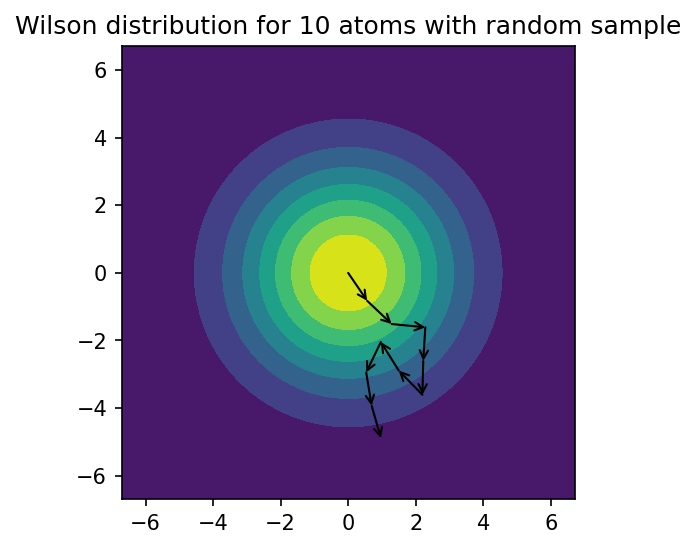

In [13]:
# Define Wilson distribution for acentric case (complex normal centered on zero)
# Python doesn't have a complex normal distribution, but it can be treated as a
# bivariate normal distributions with independent components of equal variance

fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_dpi(150)
ax.set_aspect("equal")
ax.set_title("Wilson distribution for 10 atoms with random sample")

SigmaN = 10.
sigma1D = np.sqrt(SigmaN/2)
Sigma = np.array([[SigmaN/2, 0],[0, SigmaN/2]])
mu = np.array([0,0])

x, y, pos = make_grid(np.array((0,0)),np.array((sigma1D,sigma1D))) # 2D grid for plotting
complexdist = stats.multivariate_normal(mu,Sigma) # Define the distribution
plt.contourf(x,y,complexdist.pdf(pos)) # Plot over grid

start = np.array([0,0])
for i in range(0,10):
    random_angle = 2*np.pi*np.random.random_sample()
    random_unit_vector = np.array([np.cos(random_angle),np.sin(random_angle)])
    end = start + random_unit_vector
    annotate_arrow(ax, start, end)
    start = end
    
plt.show()

### Exercise on generating a random sample in the complex plane

Make a copy of the code above and change it so it doesn't draw arrows but instead generates a large sample of structure factors, each obtained by adding random contributions from 10 atoms, then representing each result as a dot.

## The multivariate complex normal distribution

The Wilson distribution is useful, but the power of the multivariate complex normal distribution in crystallography comes from considering what we learn from correlations among sets of structure factors. These are particularly useful for phasing, as well as understanding the distributions of intensity values observed in diffraction experiments. 

Some phasing examples: molecular replacement (MR) structure solution and phasing depends on what we learn about the true structure factor from a structure factor computed from a model; ensemble models for MR depend on what we learn if we have several alternative models; isomorphous replacement phasing depends on what we learn from the correlations among structure factors from a native crystal, a heavy-atom derivative crystal, and a model of the heavy-atom substructure; phasing using anomalous diffraction (SAD and MAD) depend on what we learn from Bijvoet pairs of structure factors when there are anomalous scatterers and we have a model for the substructure.

The mathematical form of the multivariate complex normal distribution looks very much like the one for the multivariate normal distribution of real numbers, except for small changes like the ones we made to get the univariate complex normal distribution.

$p(\mathbf{z}) = (|\pi\boldsymbol{\Sigma}|^{-1/2} \exp(-(\mathbf{z} - \boldsymbol{\mu})^H \boldsymbol{\Sigma}^{-1} (\mathbf{z} - \boldsymbol{\mu}))$

$\boldsymbol{\Sigma} = \left<(\mathbf{z} - \boldsymbol{\mu})(\mathbf{z} - \boldsymbol{\mu})^H\right>$  
$= \begin{bmatrix} 
\left<(\mathbf{z}_1 - \boldsymbol{\mu}_1)(\mathbf{z}_1 - \boldsymbol{\mu}_1)^{*}\right> & \cdots & \left<(\mathbf{z}_1 - \boldsymbol{\mu}_1)(\mathbf{z}_k - \boldsymbol{\mu}_k)^{*}\right> \\
\vdots & \ddots & \vdots \\
\left<(\mathbf{z}_1 - \boldsymbol{\mu}_1)(\mathbf{z}_k - \boldsymbol{\mu}_k)^{*}\right>^{*} & \cdots & \left<(\mathbf{z}_k - \boldsymbol{\mu}_k)(\mathbf{z}_k - \boldsymbol{\mu}_k)^{*}\right> 
\end{bmatrix}$

In this equation we see the superscript $H$, indicating a Hermitian transpose. This differs from the normal transpose in taking the complex conjugate of each term at the same time as transposing the matrix or vector. As a result, the covariance matrix is no longer symmetric, but has Hermitian symmetry: element $ji$ is the complex conjugate of element $ij$. That can be seen in the representative off-diagonal terms in the expanded-out covariance matrix. In many cases, the complex covariances are real numbers so that, in practice, the complex covariance matrix is symmetric. However, if the relationship between two complex random variables involves a systematic phase shift, the corresponding covariance elements will indeed be complex numbers.

Apart from these differences, the multivariate complex normal distribution behaves like the multivariate normal distribution for real numbers. In particular, the same manipulations are used to obtain conditional probability distributions or probability distributions for linear combinations of variables.

With that background, we can look at a few examples from crystallography.


### Statistical effect of symmetry on intensities 

Most space groups have different expected intensity factors for different classes of reflections. This arises because of the interference between Fourier terms from symmetry-related molecules: for some *hkl* values the average intensity is increased, whereas for others the intensity may be constrained to zero (systematic absence).

To derive and understand the expected intensities, we only need to work with a covariance matrix, where the diagonal elements are the variances of the structure factors, which are in turn equivalent to the expected intensities.

Consider a very simple space group, $P2$, where for every atom at position $x,y,z$, there is a symmetry-related atom at $-x,y,-z$. For simplicity, we'll just consider the case where there is one molecule per asymmetric unit. The contribution to the structure factor of the atoms in one molecule is the following:

$\mathbf{F}_1(h,k,l) = \sum_j f_j \exp(2\pi\,i\,(hx_j+ky_j+lz_j)$

If the molecule has no internal symmetry then (to a very good approximation) only Friedel symmetry ($\mathbf{F}_1(h,k,l) = \mathbf{F}_1(-h,-k,-l)^{*}$) applies and contributions to different *hkl* values are otherwise independent of each other. In $P2$, the contribution of the symmetry-related molecule is the following:

$\mathbf{F}_2(h,k,l) = \sum_j f_j \exp(2\pi\,i\,(-hx_j+ky_j-lz_j) = \mathbf{F}_1(-h,k,-l)$

So we see that $\mathbf{F}_1(h,k,l)$ and $\mathbf{F}_2(h,k,l)$ are uncorrelated, except when $(h,k,l) = (-h,k,-l)$, *i.e.* when $h=l=0$. This means that, for the *0k0* class of reflections, the contributions of the two symmetry-related molecules are perfectly correlated.

Since $\mathbf{F}(h,k,l) = \mathbf{F}_1(h,k,l) + \mathbf{F}_2(h,k,l)$ we can work out the expected value of the intensity as a function of the reflection indices. The covariance matrix between $\mathbf{F}_1(h,k,l)$ and $\mathbf{F}_2(h,k,l)$ is the following:

$\begin{bmatrix}\Sigma_N/2 & \left<\mathbf{F}_1 \mathbf{F}_2^{*}\right> \\
\left<\mathbf{F}_1 \mathbf{F}_2^{*}\right>^{*} & \Sigma_N/2
\end{bmatrix}$

If $h \neq 0$ or $l \neq 0$, the two symmetry-related contributions are uncorrelated ($\left<\mathbf{F}_1 \mathbf{F}_2^{*}\right> = 0$), but if $h$ and $k$ are both zero then the symmetry-related contributions are perfectly correlated ($\left<\mathbf{F}_1 \mathbf{F}_2^{*}\right> = \Sigma_N/2$). Since the variance of $\mathbf{F}$ (which is equivalent to the expected intensity) is the sum of the covariance elements, the expected intensity is $\Sigma_N$ for the general reflections, but $2\Sigma_N$ for the *0k0* reflections. In other words, the expected intensity factor for *0k0* reflections is two. Note in this case that there is no systematic phase shift between $\mathbf{F}_1$ and $\mathbf{F}_2$, so their covariances are real numbers and $\left<\mathbf{F}_1 \mathbf{F}_2^{*}\right> = \left<\mathbf{F}_1 \mathbf{F}_2^{*}\right>^{*}$.

Systematic phase shifts arise in some space groups, with space group $P2_1$ being the simplest example. In this space group, atoms in the symmetry-related copy are found at $-x,\frac{1}{2}+y,-z$. The contribution of the first copy to the structure factor is the same as in $P2$, but the screw translation changes the contribution of the second copy:

$\mathbf{F}_2(h,k,l) = \sum_j f_j \exp(2\pi\,i\,(-hx_j+k(y_j+\frac{1}{2})-lz_j) = \mathbf{F}_1(-h,k,-l)\exp(2\pi\,i\frac{k}{2})$

This means that, for *0k0* reflections where *k* is even, there is no phase shift and the expected intensity factor will be 2, as in the case of $P2$. However, for *0k0* reflections where *k* is odd, the two symmetry-related contributions will be out of phase by $\pi$ or 180 degrees. In other words for the *k* odd *0k0* reflections, 

$\mathbf{F}_2(0,k,0) = -\mathbf{F}_1(0,k,0)$

so they will cancel and the expected intensity factor is zero.

#### Advanced optional exercise: expected intensities in $P3_1$

Work out the expected intensity of *00l* reflections in the space group $P3_1$, where atoms in the symmetry-related copies are found at $-y,x-y,\frac{1}{3}+z$ and $-x+y,-x,\frac{2}{3}+z$. 

There's a bit of a trick here: first express the symmetry-related coordinates in terms of a transformation matrix and a vector, *e.g.* for the second copy, and use the transpose operator explicitly instead of notation for the dot product.

$\mathbf{x}_2 = \mathbf{S}_2 \mathbf{x}_1 + \mathbf{t}_2$

$\mathbf{F}_2(\mathbf{h}) = \sum_j f_j \exp[2\pi\,i\,\mathbf{h}^T (\mathbf{S}_2 (\mathbf{x}_j + \mathbf{t}_2))]$

Then work out why this can alternatively be expressed in this way:

$\mathbf{F}_2(\mathbf{h}) = \sum_j f_j \exp[2\pi\,i\,(\mathbf{S}_2^T\,\mathbf{h})^T (\mathbf{x}_j + \mathbf{t})]$

which means that the symmetry operation in reciprocal space is the transpose of the symmetry operation in real space!

Once you have done this, make sure you understand why the *00l* reflections are the ones with altered expected intensity factors. This involves the phase shifts resulting from the screw translations of the symmetry-related copies. How do the terms for the symmetry-related copies add up for different values of *l*?

### Statistical effect of translational non-crystallographic symmetry (tNCS)

We won't go into detail here, but the basic principles are the same as for the expected intensity factor arising from symmetry. If two copies of molecules within the asymmetric unit of a crystal are related by a pure translation, their contributions to the total structure factor will have the same magnitude but systematically different phases (depending on the dot product between *hkl* and the fractional translation vector). This has a statistical effect on the expected intensities. The situation is more complicated than the symmetry case because the translation vectors usually aren't rational numbers, and the tNCS-related copies usually differ somewhat in conformation or orientation, reducing the strength of the correlation terms. 

If you're interested, you can read more here: https://doi.org/10.1107/S0907444912045374.

### Conditional probability of the true structure factor given a model

If the atomic model of a crystal bears any resemblance to the true crystal, the structure factors computed from the model will be correlated to the true structure factors. This gives us phase information, but it's useful to know how reliable that phase information is. For that reason, we're interested in knowing the conditional probability of the true structure factor given the structure factor computed from a model.

For simplicity, we'll avoid symmetry and consider a crystal in space group $P1$. We'll start with one particularly simple case: where we have a perfect model for part of the structure but know nothing about the rest of the structure. This is a situation that was considered by Sim for the acentric case and by Woolfson for the centric case.

Assuming that our molecule contains a sufficient number of atoms and none of them dominate, we can assume that both  structure factor contributions, from the modeled part and the missing part, are drawn from a complex normal distribution. The two contributions will, in general, be independent of each other (unless the two parts are similar *and* in a similar orientation). So we can easily make a covariance matrix for the joint distribution of these structure factor contributions. Traditionally, the known atoms are called the *P* atoms and the missing atoms the *Q* atoms. Here is the 2x2 covariance matrix with no correlations:

$\boldsymbol{\Sigma}_{PQ} = \begin{bmatrix}
\Sigma_P & 0 \\ 0 & \Sigma_Q
\end{bmatrix}$

We want to look at the relationship between the total structure factor:

$\mathbf{F}_N = \mathbf{F}_P + \mathbf{F}_Q$

and just the $\mathbf{F}_P$ component. To do this we can define a matrix $\mathbf{A}$ that transforms $\mathbf{F}_P$ and $\mathbf{F}_Q$ into $\mathbf{F}_P + \mathbf{F}_Q$ ($=\mathbf{F}_N$) and $\mathbf{F}_P$.

$\mathbf{A} = \begin{bmatrix}
1 & 1 \\
1 & 0 \end{bmatrix}$

$\boldsymbol{\Sigma}_{NP} = \mathbf{A} \boldsymbol{\Sigma}_{PQ} \mathbf{A}^T$

$\boldsymbol{\Sigma}_{NP} =
\begin{bmatrix}
1 & 1 \\
1 & 0 \end{bmatrix}
\begin{bmatrix}
\Sigma_P & 0 \\ 0 & \Sigma_Q
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\
1 & 0 \end{bmatrix} =
\begin{bmatrix}
1 & 1 \\
1 & 0 \end{bmatrix}
\begin{bmatrix}\Sigma_P & \Sigma_P \\ 
\Sigma_Q & 0 \end{bmatrix}$

$\boldsymbol{\Sigma}_{NP} =
\begin{bmatrix}\Sigma_P + \Sigma_Q & \Sigma_P \\ 
\Sigma_P & \Sigma_P \end{bmatrix} =
\begin{bmatrix}\Sigma_N & \Sigma_P \\ 
\Sigma_P & \Sigma_P \end{bmatrix}$

We can turn this into a correlation matrix by dividing every covariance matrix element by the square roots of the corresponding diagonal elements:

$\begin{bmatrix}1 & \sqrt{\frac{\Sigma_P}{\Sigma_N}} \\ 
\sqrt{\frac{\Sigma_P}{\Sigma_N}} & 1 \end{bmatrix}$

In other words, the complex correlation between $\mathbf{F}_N$ and $\mathbf{F}_P$ is the square root of the fraction of the total scattering accounted for by the model.

Finally, to get the conditional distribution of $\mathbf{F}_N$ given $\mathbf{F}_P$, we need the conditional variance and expected values. Note that before we have a model, the expected values of both $\mathbf{F}_N$ and $\mathbf{F}_P$ are zero.

$\Sigma_{N|P} = \Sigma_N - \Sigma_P\,\Sigma_P^{-1}\,\Sigma_P = \Sigma_N - \Sigma_P = \Sigma_Q$

$\left<\mathbf{F}_N\right>_{F_P} = 0 + \Sigma_P\,\Sigma_P^{-1}\,(\mathbf{F}_P - 0) = \mathbf{F}_P$

$p(\mathbf{F}_N;\mathbf{F}_P) = \frac{1}{\pi\Sigma_Q}\exp(-\frac{|\mathbf{F}_N-\mathbf{F}_P|^2}{\Sigma_Q})$

Compared to the Wilson distribution in that the centre of the distribution has moved from the origin to $\mathbf{F}_P)$, and the distribution at that point is just the re-positioned Wilson distribution for $\mathbf{F}_Q)$. This is illustrated below, with a randomly chosen value for $\mathbf{F}_N$ (and the choice of $\mathbf{F}_Q$ that implies) that you can regenerate by rerunning the cell.

-6.2132034355964265 36.21320343559643 -9.213203435596427 33.21320343559643
[15. 12.]
[7.07106781 7.07106781]


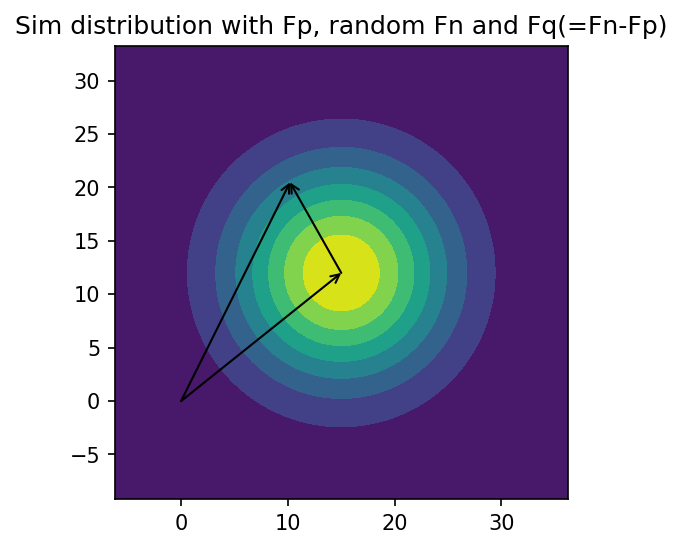

In [15]:
# Define Sim distribution for acentric case (complex normal centered on partial
# structure factor)

fig, ax = plt.subplots()
ax.set_aspect("equal")
fig.set_dpi(150)
ax.set_aspect("equal")
ax.set_title("Sim distribution with Fp, random Fn and Fq(=Fn-Fp)")

# Define F_P as real, imaginary pair to provide to bivariate normal
fp = np.array([15.,12.])
SigmaQ = 100.
sigma1D = np.sqrt(SigmaQ/2)
Sigma = np.array([[SigmaQ/2, 0],[0, SigmaQ/2]])
mu = fp

xmin = min(0.,fp[0]-3*sigma1D)
xmax = max(0.,fp[0]+3*sigma1D)
ymin = min(0.,fp[1]-3*sigma1D)
ymax = max(0.,fp[1]+3*sigma1D)
print(xmin,xmax,ymin,ymax)
centre = np.array([(xmin + xmax)/2, (ymin + ymax)/2])
print(centre)
scales = np.array([xmax-xmin,ymax-ymin]) / 6
print(scales)
x, y, pos = make_grid(centre,scales) # 2D grid for plotting
complexdist = stats.multivariate_normal(mu,Sigma) # Define the distribution
plt.contourf(x,y,complexdist.pdf(pos)) # Plot over grid

start = np.array([0,0])
end = np.random.multivariate_normal(mu,Sigma)
annotate_arrow(ax, start, fp)
annotate_arrow(ax, fp, end)
annotate_arrow(ax, start, end)
    
plt.show()

For real cases, we would need to consider the effect of coordinate errors (and B-factor errors and errors in identifying the correct atom type) on the accuracy of the calculated structure factor, but that would be beyond the scope of the time we have. In brief, errors in the model reduce the strength of the covariance terms. The case of random coordinate errors for a complete model was considered by Luzzati in the 1950s. To deal with this, we need to consider the expected value and variance of the contribution of an atom shifted from its correct position. The combination of model error and incompleteness was considered by Srinivasan and coworkers in the 1960s and 1970s.

### Advanced optional exercise: multiple components and ensemble models in MR

Think about what would happen if you were either adding multiple components for different parts of the structure, or adding an ensemble of superimposed alternative models. What would the covariance matrix for the true structure factor and structure factors computed from the correctly-placed multiple models look like? What would the conditional probability distribution for the true structure factor given the collection of models look like in these cases? Why is it different when you add alternative models for the same thing compared to when you add models for different parts of the structure?

### Going further

All phasing methods can be approached starting by constructing covariance matrices relating appropriate sets of structure factors. The knowledge provided by models (and by having measurements of the amplitudes of the structure factors, not addressed here) restricts the possibilities for phase angles.

Isomorphous replacement phasing can be approached by starting from the covariance matrix relating structure factors from a native crystal, one or more heavy-atom derivative crystals, and one or more models of the heavy-atom substructures.

Phasing by anomalous dispersion requires looking at the Friedel pairs of reflections, which are highly correlated but which are not identical because of the effect of the anomalous scatterers.

Constructing the appropriate multivariate complex normal distributions for different phasing cases is actually relatively straightforward compared to the other steps required to make a likelihood target for phasing and refinement. The likelihood target is the probability distribution for the set of measurements we made, given the parameters describing our model. Unfortunately, we are not able to measure the phase information directly, so all we have are intensities (with measurement errors), from which we can infer approximate values for the amplitudes of the structure factors. The phases, then, are *nuisance variables* that we have to integrate out from our structure factor probability distributions. This requires a change of variables and then an integration over every unknown phase angle, which (for multiple measurements) is a much more difficult problem, beyond the scope we can cover here!

If you're interested, you could look at these papers:

Likelihood in molecular replacement: https://doi.org/10.1107/S0907444901012471

Likelihood in SAD phasing: https://doi.org/10.1107/S0907444904009990

Likelihood-based methods in Phaser: https://doi.org/10.1107/s0021889807021206

Likelihood in MIR phasing: https://doi.org/10.1107/s0907444903017918

## Bonus optional exercise!
If you spot some inelegant Python code (probably not a big challenge) and work out a more elegant way to do it, let me know!